# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('/home/junpenglao/Documents/pymc3/docs/source/data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [2]:
@pm.model
def hierarchical_model(data, county_idx):  
    # Hyperpriors
    mu_a = yield pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = yield pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = yield pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = yield pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal('alpha', mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal('beta', mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()))
    
    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

In [3]:
%%time
model = hierarchical_model(data, county_idx)
pm4_trace, _ = pm.inference.sampling.sample(
    model, num_chains=100, num_samples=10, burn_in=10, step_size=1., xla=False)

W0907 00:33:33.389019 139889341269824 deprecation.py:323] From /home/junpenglao/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1404: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 40.3 s, sys: 1.5 s, total: 41.9 s
Wall time: 24.3 s


### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [10]:
num_chains = 100
for i in range(2):
    step_size_ = []
    for key, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))
    model = hierarchical_model(data, county_idx)
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i, step_size=1., xla=False)

In [11]:
%%time
num_chains = 5
step_size_ = []
for key, x in pm4_trace.items():
    std = tf.math.reduce_std(x, axis=[0, 1])
    step_size_.append(
        std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

pm4_trace, sample_stat = pm.inference.sampling.sample(
    model, num_chains=num_chains, num_samples=500, burn_in=100,
    step_size=step_size_, xla=False)

CPU times: user 1min 27s, sys: 7.65 s, total: 1min 35s
Wall time: 45.7 s


In [12]:
az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)

In [15]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/mu_alpha,1.487,0.051,1.388,1.582,0.001,0.001,1716.0,1713.0,1714.0,2027.0,1.00
hierarchical_model/__log_sigma_beta,-1.277,0.399,-2.131,-0.631,0.062,0.045,41.0,40.0,51.0,97.0,1.10
hierarchical_model/__log_sigma_alpha,-1.140,0.143,-1.389,-0.859,0.004,0.003,1026.0,1026.0,1028.0,1629.0,1.01
hierarchical_model/alpha[0],1.206,0.244,0.752,1.660,0.004,0.003,3256.0,2998.0,3234.0,1784.0,1.00
hierarchical_model/alpha[1],0.986,0.096,0.809,1.167,0.002,0.001,3668.0,3575.0,3661.0,1575.0,1.00
hierarchical_model/alpha[2],1.492,0.274,0.980,2.012,0.004,0.003,4126.0,4037.0,4110.0,1797.0,1.00
hierarchical_model/alpha[3],1.543,0.229,1.133,1.989,0.004,0.003,3172.0,3147.0,3178.0,1943.0,1.00
hierarchical_model/alpha[4],1.462,0.240,1.019,1.902,0.004,0.003,4221.0,4221.0,4179.0,1954.0,1.00
hierarchical_model/alpha[5],1.509,0.262,1.006,2.013,0.004,0.003,4970.0,4675.0,4969.0,1848.0,1.00
hierarchical_model/alpha[6],1.847,0.171,1.537,2.168,0.003,0.002,3410.0,3328.0,3431.0,1977.0,1.00


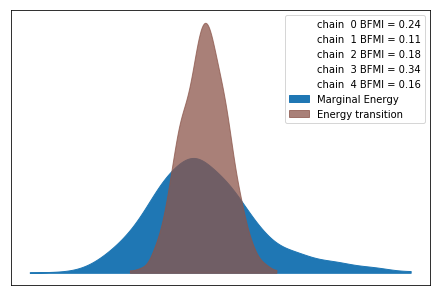

In [13]:
az.plot_energy(az_trace);

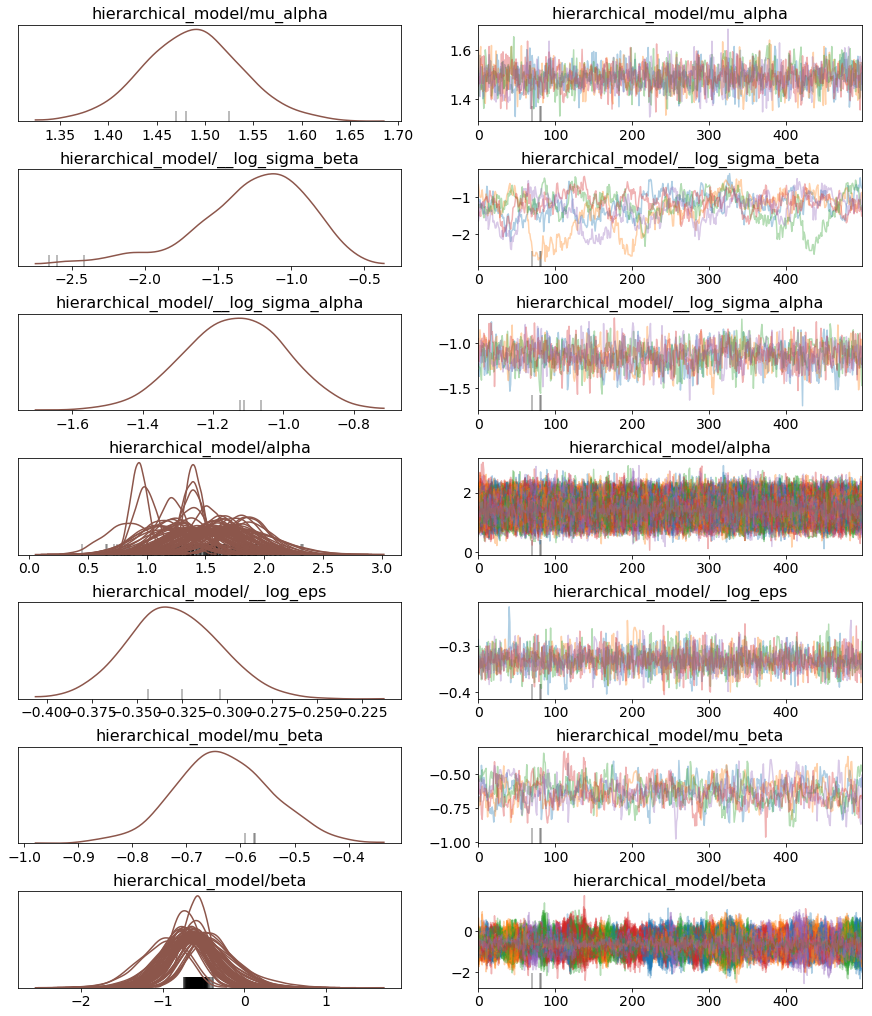

In [14]:
az.plot_trace(az_trace, compact=True, combined=True);